In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2025-09-02 13:39:34.629823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756820374.826154      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756820374.884515      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_path = "/kaggle/input/movie-lens-small-latest-dataset" 
print(os.listdir(data_path))

['movies.csv', 'ratings.csv', 'README.txt', 'tags.csv', 'links.csv']


In [3]:
movies = pd.read_csv("/kaggle/input/movie-lens-small-latest-dataset/movies.csv")
df = pd.read_csv("/kaggle/input/movie-lens-small-latest-dataset/ratings.csv")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# Encode users and movies to consecutive integers
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

df['user_id'] = user_encoder.fit_transform(df['userId'])
df['movie_id'] = movie_encoder.fit_transform(df['movieId'])

n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()

# Convert ratings to implicit feedback 1 if rating >= 4, 0 otherwise
df['implicit_rating'] = (df['rating'] >= 4.0).astype(int)

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, 
                                   stratify=df['user_id'])

In [5]:
# Graph construction

def create_adjacency_matrix(train_df, n_users, n_movies):
    """Create normalized adjacency matrix for user-item bipartite graph"""
    # Create user-item interaction matrix
    rows = train_df['user_id'].values
    cols = train_df['movie_id'].values
    data = train_df['implicit_rating'].values
    
    # User-item matrix (users x movies)
    user_item = sp.csr_matrix((data, (rows, cols)), shape=(n_users, n_movies))
    
    # Create bipartite adjacency matrix
    # Structure: [0,    R  ]
    #            [R^T,  0  ]
    adj_matrix = sp.bmat([[None, user_item], [user_item.T, None]])
    
    # Add self-loops and normalize
    adj_matrix = adj_matrix + sp.eye(adj_matrix.shape[0])
    
    # Degree normalization: D^(-1/2) * A * D^(-1/2)
    degree = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_inv_sqrt = np.power(degree, -0.5)
    degree_inv_sqrt[np.isinf(degree_inv_sqrt)] = 0.0
    degree_mat_inv_sqrt = sp.diags(degree_inv_sqrt)
    
    norm_adj = degree_mat_inv_sqrt @ adj_matrix @ degree_mat_inv_sqrt
    
    return norm_adj.tocoo()

# Create adjacency matrix
adj_matrix = create_adjacency_matrix(train_df, n_users, n_movies)

# Convert to TensorFlow SparseTensor
indices = np.column_stack([adj_matrix.row, adj_matrix.col])
values = adj_matrix.data.astype(np.float32)
shape = adj_matrix.shape

adj_tensor = tf.SparseTensor(indices=indices, values=values, dense_shape=shape)

I0000 00:00:1756820469.159751      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756820469.160443      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
class LightGCNLayer(layers.Layer):
    """Custom layer for LightGCN graph convolution"""
    
    def __init__(self, **kwargs):
        super(LightGCNLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        embeddings, adj_matrix = inputs
        # Graph convolution: A * embeddings
        return tf.sparse.sparse_dense_matmul(adj_matrix, embeddings)

class LightGCN(keras.Model):
    """LightGCN model implementation"""
    
    def __init__(self, n_users, n_items, embedding_dim=64, n_layers=3, **kwargs):
        super(LightGCN, self).__init__(**kwargs)
        
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        
        # Embedding layers
        self.user_embedding = layers.Embedding(
            n_users, embedding_dim, 
            embeddings_initializer='glorot_normal',
            name='user_embedding'
        )
        self.item_embedding = layers.Embedding(
            n_items, embedding_dim,
            embeddings_initializer='glorot_normal',
            name='item_embedding'
        )
        
        # Graph convolution layers
        self.gcn_layers = [LightGCNLayer(name=f'gcn_{i}') for i in range(n_layers)]
        
        # Mean pooling layer
        self.mean_pooling = layers.Average()
    
    def call(self, inputs, training=None):
        adj_matrix = inputs
        
        # Get initial embeddings
        user_embeddings = self.user_embedding(tf.range(self.n_users))
        item_embeddings = self.item_embedding(tf.range(self.n_items))
        
        # Concatenate user and item embeddings
        all_embeddings = tf.concat([user_embeddings, item_embeddings], axis=0)
        
        # Store embeddings from each layer
        embeddings_list = [all_embeddings]
        
        # Apply graph convolution layers
        current_embeddings = all_embeddings
        for gcn_layer in self.gcn_layers:
            current_embeddings = gcn_layer([current_embeddings, adj_matrix])
            embeddings_list.append(current_embeddings)
        
        # Mean pooling across all layers
        final_embeddings = self.mean_pooling(embeddings_list)
        
        # Split back to user and item embeddings
        user_final = final_embeddings[:self.n_users]
        item_final = final_embeddings[self.n_users:]
        
        return user_final, item_final
    
    def predict_ratings(self, user_ids, item_ids):
        """Predict ratings for given user-item pairs"""
        user_emb, item_emb = self(adj_tensor)
        
        user_vectors = tf.gather(user_emb, user_ids)
        item_vectors = tf.gather(item_emb, item_ids)
        
        # Dot product for rating prediction
        ratings = tf.reduce_sum(user_vectors * item_vectors, axis=1)
        return ratings

In [7]:
class BPRDataGenerator:
    """Data generator for BPR training"""
    
    def __init__(self, train_df, n_users, n_movies, batch_size=2048, negative_ratio=1):
        self.train_df = train_df
        self.n_users = n_users
        self.n_movies = n_movies
        self.batch_size = batch_size
        self.negative_ratio = negative_ratio
        
        # Create user-item interaction dictionary
        self.user_items = train_df.groupby('user_id')['movie_id'].apply(set).to_dict()
        
        # Positive interactions
        self.pos_users = train_df['user_id'].values
        self.pos_items = train_df['movie_id'].values
        
    def generate_batch(self):
        """Generate a batch of positive and negative samples"""
        # Sample positive interactions
        indices = np.random.choice(len(self.pos_users), size=self.batch_size, replace=True)
        batch_users = self.pos_users[indices]
        batch_pos_items = self.pos_items[indices]
        
        # Sample negative items
        batch_neg_items = []
        for user_id in batch_users:
            user_positive_items = self.user_items.get(user_id, set())
            while True:
                neg_item = np.random.randint(0, self.n_movies)
                if neg_item not in user_positive_items:
                    batch_neg_items.append(neg_item)
                    break
        
        return (tf.constant(batch_users), 
                tf.constant(batch_pos_items), 
                tf.constant(batch_neg_items))

In [16]:
# Loss functions and training
@tf.function
def bpr_loss(pos_scores, neg_scores):
    """Bayesian Personalized Ranking loss"""
    loss = -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(pos_scores - neg_scores) + 1e-8))
    return loss

@tf.function
def train_step(model, optimizer, users, pos_items, neg_items, reg_lambda=1e-4):
    """Single training step"""
    with tf.GradientTape() as tape:
        # Forward pass
        pos_scores = model.predict_ratings(users, pos_items)
        neg_scores = model.predict_ratings(users, neg_items)
        
        # BPR loss
        loss = bpr_loss(pos_scores, neg_scores)
        
        # L2 regularization
        reg_loss = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
        total_loss = loss + reg_lambda * reg_loss
    
    # Compute gradients and update weights
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return total_loss

@tf.function
def test_step(model, users, pos_items, neg_items, reg_lambda=1e-4):
    """Test step (no gradient update)"""
    pos_scores = model.predict_ratings(users, pos_items)
    neg_scores = model.predict_ratings(users, neg_items)
    
    # BPR loss
    loss = bpr_loss(pos_scores, neg_scores)
    
    # L2 regularization
    reg_loss = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
    total_loss = loss + reg_lambda * reg_loss
    
    return total_loss

def train_lightgcn(model, train_df, val_df, n_epochs=50, batch_size=2048, 
                   learning_rate=0.001, reg_lambda=1e-4):
    """Train LightGCN model with validation tracking"""
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Data generators
    train_gen = BPRDataGenerator(train_df, n_users, n_movies, batch_size)
    test_gen = BPRDataGenerator(test_df, n_users, n_movies, batch_size)
    
    train_losses, test_losses = [], []
    steps_per_epoch = len(train_df) // batch_size
    test_steps = max(1, len(test_df) // batch_size)
    
    for epoch in range(n_epochs):
        # ---- Training ----
        epoch_losses = []
        for step in range(steps_per_epoch):
            users, pos_items, neg_items = train_gen.generate_batch()
            loss = train_step(model, optimizer, users, pos_items, neg_items, reg_lambda)
            epoch_losses.append(loss.numpy())
        avg_train_loss = np.mean(epoch_losses)
        train_losses.append(avg_train_loss)
        
        # ---- Test ----
        test_epoch_losses = []
        for step in range(test_steps):
            users, pos_items, neg_items = test_gen.generate_batch()
            test_loss = test_step(model, users, pos_items, neg_items, reg_lambda)
            test_epoch_losses.append(test_loss.numpy())
        avg_test_loss = np.mean(test_epoch_losses)
        test_losses.append(avg_test_loss)
        
        print(f"Epoch {epoch+1:3d}/{n_epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")
    
    return train_losses, test_losses

In [17]:
def evaluate_model(model, test_df, k=10):
    """Evaluate model using Precision@K, Recall@K, and NDCG@K"""
    
    # Get embeddings
    user_embeddings, item_embeddings = model(adj_tensor)
    
    # Get unique users in test set
    test_users = test_df['user_id'].unique()
    
    precisions = []
    recalls = []
    ndcgs = []
    
    for user_id in tqdm(test_users, desc="Evaluating"):
        # Get test items for this user
        user_test_items = set(test_df[test_df['user_id'] == user_id]['movie_id'].values)
        
        # Get training items for this user (to exclude from recommendations)
        user_train_items = set(train_df[train_df['user_id'] == user_id]['movie_id'].values)
        
        # Calculate scores for all items
        user_emb = tf.gather(user_embeddings, [user_id])
        scores = tf.linalg.matvec(item_embeddings, user_emb[0])
        
        # Exclude training items
        scores_array = scores.numpy()
        for item_id in user_train_items:
            scores_array[item_id] = -float('inf')
        
        # Get top-k recommendations
        top_k_items = np.argsort(scores_array)[-k:][::-1]
        
        # Calculate metrics
        relevant_items = len(set(top_k_items) & user_test_items)
        
        precision = relevant_items / k
        recall = relevant_items / len(user_test_items) if len(user_test_items) > 0 else 0
        
        # NDCG calculation
        dcg = sum([1 / np.log2(i + 2) for i, item in enumerate(top_k_items) 
                  if item in user_test_items])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(user_test_items), k))])
        ndcg = dcg / idcg if idcg > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
    
    return {
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'ndcg': np.mean(ndcgs)
    }

Model parameters: 661376

Model architecture:


Model: "light_gcn_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)           │ (610, 64)                   │          39,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ item_embedding (Embedding)           │ (9724, 64)                  │         622,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gcn_0 (LightGCNLayer)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gcn_1 (LightGCNLayer)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gcn_2 (LightGCNLayer)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_4 (Average)                  │ (10334, 64)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 661,376 (2.52 MB)

 Trainable params: 661,376 (2.52 MB)

 Non-trainable params: 0 (0.00 B)


Training LightGCN...
Epoch   1/50 | Train Loss: 0.6988 | Test Loss: 0.6937
Epoch   2/50 | Train Loss: 0.6772 | Test Loss: 0.6529
Epoch   3/50 | Train Loss: 0.6011 | Test Loss: 0.5853
Epoch   4/50 | Train Loss: 0.5444 | Test Loss: 0.5697
Epoch   5/50 | Train Loss: 0.5290 | Test Loss: 0.5658
Epoch   6/50 | Train Loss: 0.5219 | Test Loss: 0.5618
Epoch   7/50 | Train Loss: 0.5193 | Test Loss: 0.5660
Epoch   8/50 | Train Loss: 0.5184 | Test Loss: 0.5697
Epoch   9/50 | Train Loss: 0.5187 | Test Loss: 0.5612
Epoch  10/50 | Train Loss: 0.5162 | Test Loss: 0.5654
Epoch  11/50 | Train Loss: 0.5183 | Test Loss: 0.5583
Epoch  12/50 | Train Loss: 0.5165 | Test Loss: 0.5627
Epoch  13/50 | Train Loss: 0.5165 | Test Loss: 0.5667
Epoch  14/50 | Train Loss: 0.5164 | Test Loss: 0.5658
Epoch  15/50 | Train Loss: 0.5144 | Test Loss: 0.5630
Epoch  16/50 | Train Loss: 0.5146 | Test Loss: 0.5614
Epoch  17/50 | Train Loss: 0.5158 | Test Loss: 0.5638
Epoch  18/50 | Train Loss: 0.5167 | Test Loss: 0.5624
Epoch 

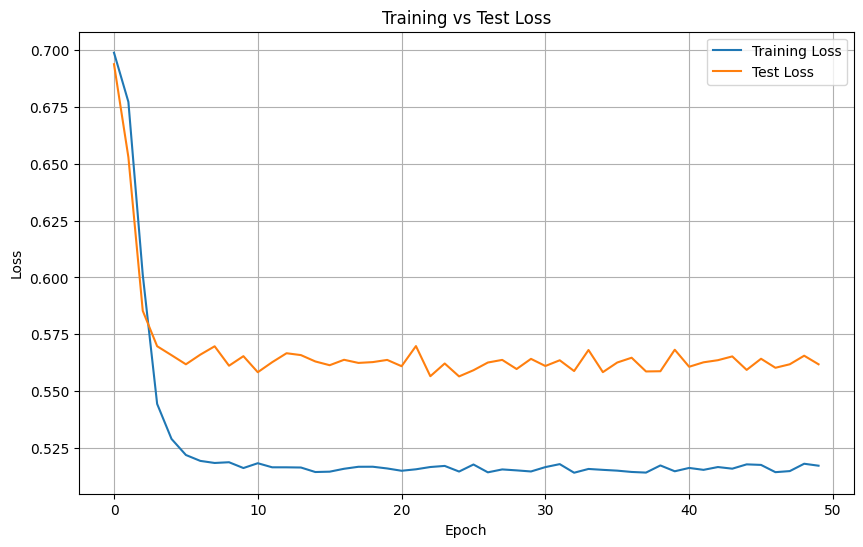


Evaluating model...


Evaluating: 100%|██████████| 610/610 [00:01<00:00, 340.80it/s]


Evaluation Results:
Precision@10: 0.1608
Recall@10: 0.0757
NDCG@10: 0.1877


In [18]:
# Initialize model
model = LightGCN(n_users=n_users, n_items=n_movies, 
                 embedding_dim=64, n_layers=3)

# Build model by calling it once
_ = model(adj_tensor)

print(f"Model parameters: {model.count_params()}")
print("\nModel architecture:")
model.summary()

# Train model
print("\nTraining LightGCN...")
train_losses, test_losses = train_lightgcn(model, train_df, test_df,
                                          n_epochs=50, batch_size=2048,
                                          learning_rate=0.001, reg_lambda=1e-4)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Training vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate model
print("\nEvaluating model...")
metrics = evaluate_model(model, test_df, k=10)

print(f"\nEvaluation Results:")
print(f"Precision@10: {metrics['precision']:.4f}")
print(f"Recall@10: {metrics['recall']:.4f}")
print(f"NDCG@10: {metrics['ndcg']:.4f}")